# Mole monitoring

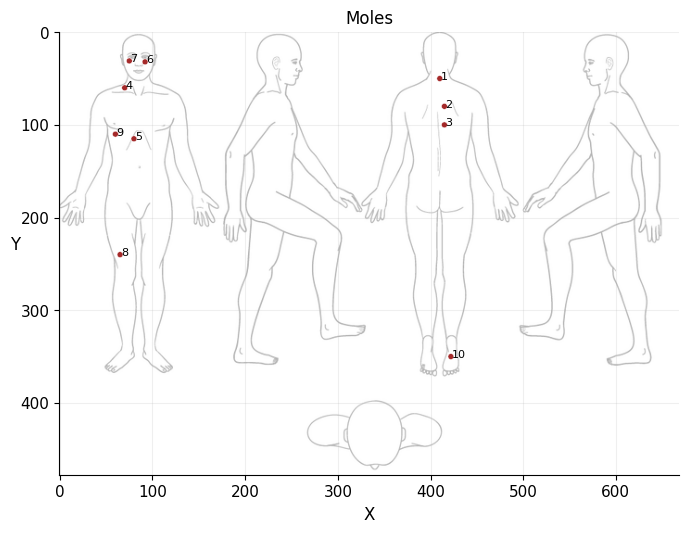

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
from transformers import pipeline

# Read data file with mole information
moles = pd.read_csv("data/moles.csv").reset_index().rename(columns={"index": "id"})
moles["id"] += 1

# Location of images
path = "images/moles/"

# Load body image for mole location reference
with Image.open(path + "bodymap.webp") as bodyimage:
    bodyimage.load()

# Plot
fig, ax = plt.subplots(figsize=(8, 8))

ax.imshow(bodyimage, alpha=0.3)

sns.scatterplot(x="x", y="y", data=moles, ax=ax, color="brown", size=3, legend=False)
add = 1.0  # To avoid overlapping
for _, row in moles.iterrows():
    ax.text(row["x"] + add, row["y"] + add, row["id"], size=8)

ax.grid(axis="both", alpha=0.2)
ax.set_axisbelow(True)
ax.tick_params(axis="x", labelsize=11, rotation=0)
ax.tick_params(axis="y", labelsize=11)
ax.set_title("Moles", size=12)
ax.set_xlabel("X", size=12)
ax.set_ylabel("Y", size=12, rotation=0)
sns.despine()

plt.show()

*Body map image downloaded from: https://www.mskcc.org/es/cancer-care/patient-education/how-do-monthly-skin-exam

{octicon}`calendar` Apr, 2024 

{bdg-success}`AI` {bdg-success-line}`Image classification`

## Background
Like many, I also have some moles on my body. The truth is, I don't pay much attention to them. However, when spring arrives, and especially in summer, my wife reminds me that I should see a doctor. She says there are some moles that should be "monitored". Just in case. But I don't take it seriously, and my wife, resigned, settles for me putting on cream and protecting myself with a hat when we go out in the sun.

However, this year it occurred to me that I could use an image classification model to identify my moles and put my wife's mind at ease. So I asked her to take photos of the moles with the macro lens of my phone and fed them to a model fine-tuned to detect skin conditions, both benign and cancerous.

## The model
In [Hugging Face](https://huggingface.co/), I filtered by image classification models and searched for those trained to detect skin cancers. Among the results, [gianlab/swin-tiny-patch4-window7-224-finetuned-skin-cancer](https://huggingface.co/gianlab/swin-tiny-patch4-window7-224-finetuned-skin-cancer) seemed to have the highest acceptance based on the number of downloads.

This model is a fine-tuned version of [microsoft/swin-tiny-patch4-window7-224](https://huggingface.co/microsoft/swin-tiny-patch4-window7-224) using the [Skin Cancer MNIST: HAM10000](https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000) dataset.

The possible classified diseases are:


(benign)

- [**Melanocytic nevus**](https://en.wikipedia.org/wiki/Melanocytic_nevus) (also known commonly as a **mole**) is usually a noncancerous condition of pigment-producing skin cells. It is a type of melanocytic tumor that contains nevus cells. Some sources equate the term mole with "melanocytic nevus", but there are also sources that equate the term mole with any nevus form.

- A [**seborrheic keratosis**](https://en.wikipedia.org/wiki/Seborrheic_keratosis) is a non-cancerous (benign) skin tumour that originates from cells, namely keratinocytes, in the outer layer of the skin called the epidermis. The tumours (also called lesions) appear in various colours, from light tan to black. They are round or oval, feel flat or slightly elevated, like the scab from a healing wound, and range in size from very small to more than 2.5 centimetres across. Because only the top layers of the epidermis are involved, seborrheic keratoses are often described as having a "pasted on" appearance.

- A [**dermatofibroma**](https://en.wikipedia.org/wiki/Dermatofibroma), or benign fibrous histiocytomas, is a benign nodule in the skin, typically on the legs, elbows or chest of an adult. It typically results from mild trauma such as an insect bite.

- A [**vascular anomaly**](https://en.wikipedia.org/wiki/Vascular_anomaly) is any of a range of lesions from a simple birthmark to a large tumor that may be disfiguring. They are caused by a disorder of the vascular system. A vascular anomaly is a localized defect in blood or lymph vessels. These defects are characterized by an increased number of vessels, and vessels that are both enlarged and sinuous. Some vascular anomalies are congenital, others appear within weeks to years after birth, and others are acquired by trauma or during pregnancy.

(cancerous)

- [**Melanoma**](https://en.wikipedia.org/wiki/Melanoma) is the _most dangerous type of skin cancer_. In women, melanomas most commonly occur on the legs; while in men, on the back. About 25% of melanomas develop from moles. Changes in a mole that can indicate melanoma include increase—especially rapid increase—in size, irregular edges, change in color, itchiness, or skin breakdown.

- [**Basal-cell carcinoma**](https://en.wikipedia.org/wiki/Basal-cell_carcinoma), also known as basal-cell cancer, basalioma or rodent ulcer, is _the most common type of skin cancer_. It often appears as a painless raised area of skin, which may be shiny with small blood vessels running over it. It may also present as a raised area with ulceration. Basal-cell cancer grows slowly and can damage the tissue around it, but it is unlikely to spread to distant areas or result in death.

- [**Actinic keratosis**](https://en.wikipedia.org/wiki/Actinic_keratosis), sometimes called solar keratosis or senile keratosis, is a pre-cancerous area of thick, scaly, or crusty skin. Actinic keratosis is a disorder of epidermal keratinocytes that is induced by ultraviolet light exposure. Given their pre-cancerous nature, if left untreated, _they may turn into a type of skin cancer_ called squamous cell carcinoma.

So, based on the Hugging Face framework, I used this model by feeding it the images of the moles saved in JPG format and defined in the CSV file where I also stored the coordinates of each of these moles.

In [8]:
moles

,id,x,y,file
0,1,410,50,01.jpg
1,2,415,80,02.jpg
2,3,415,100,03.jpg
3,4,70,60,04.jpg
4,5,80,115,05.jpg
5,6,92,32,06.jpg
6,7,75,31,07.jpg
7,8,65,240,08.jpg
8,9,60,110,09.jpg
9,10,422,350,10.jpg


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


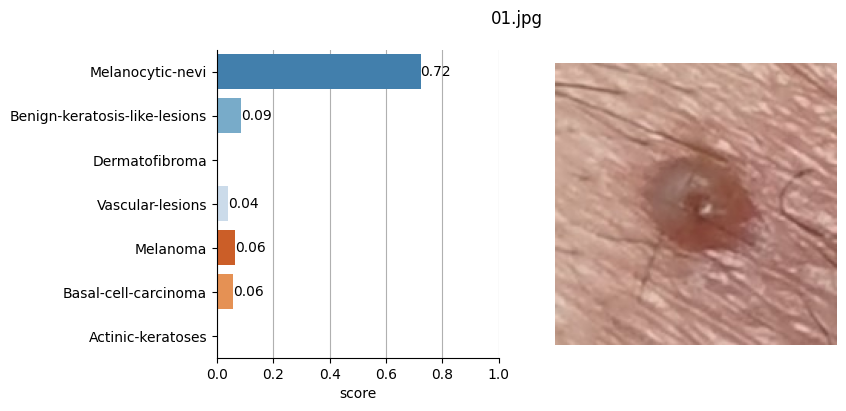

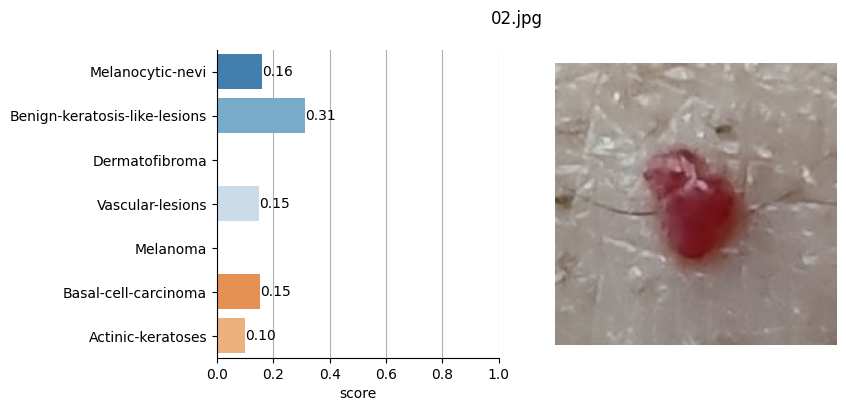

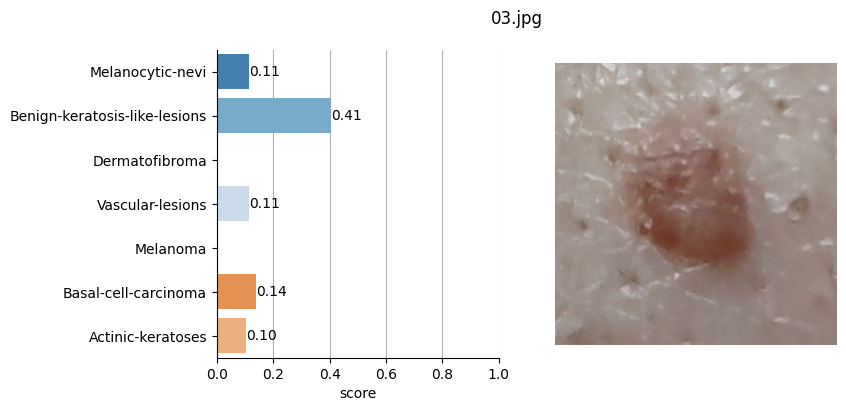

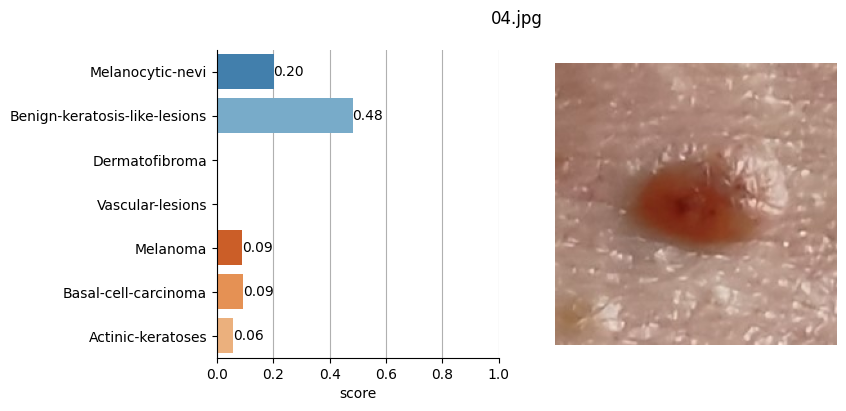

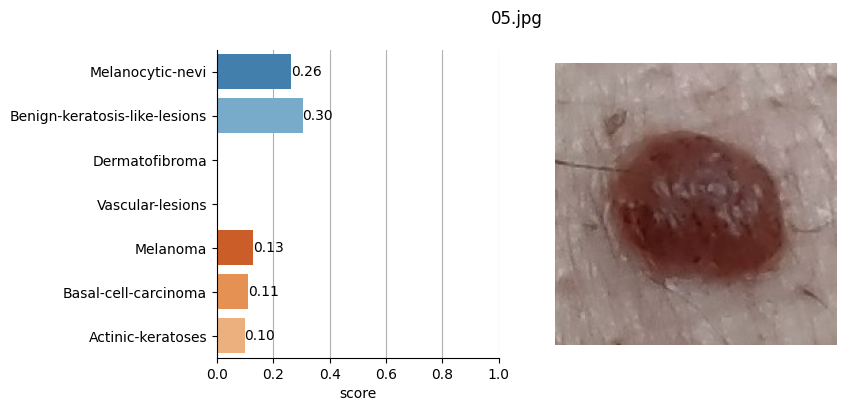

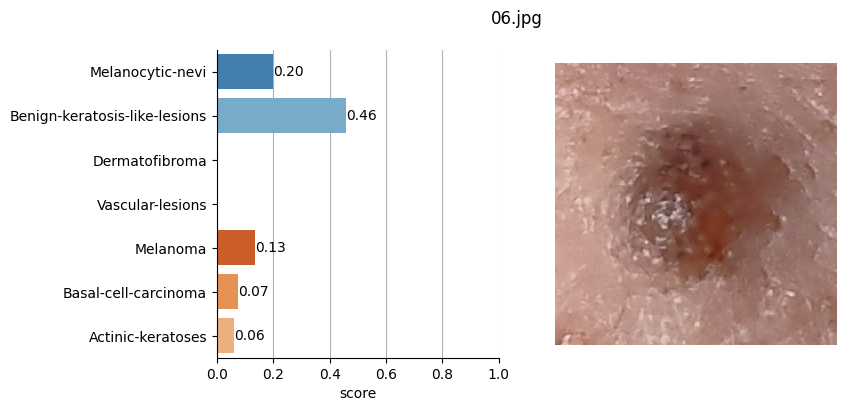

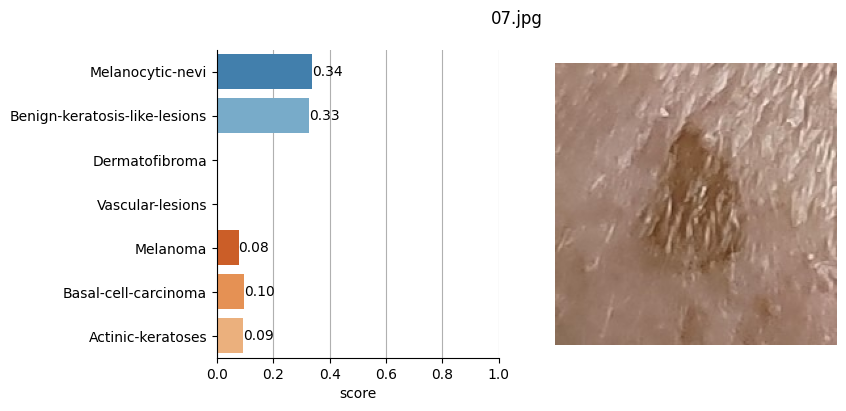

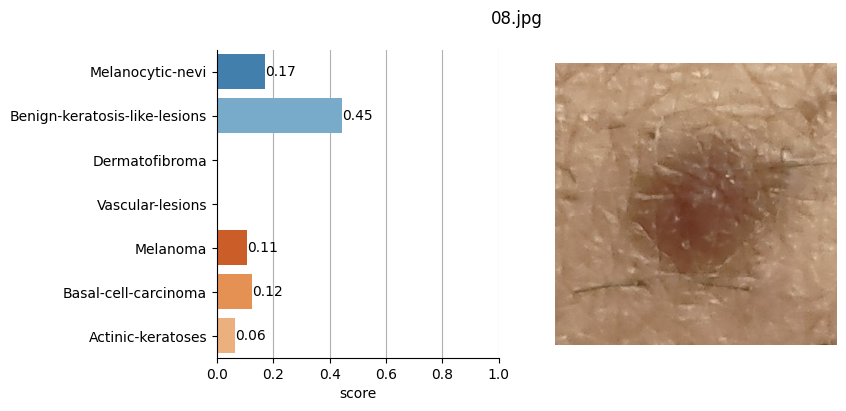

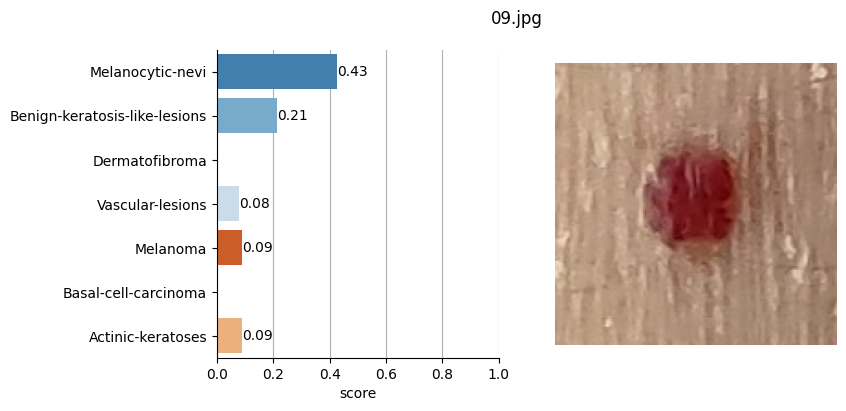

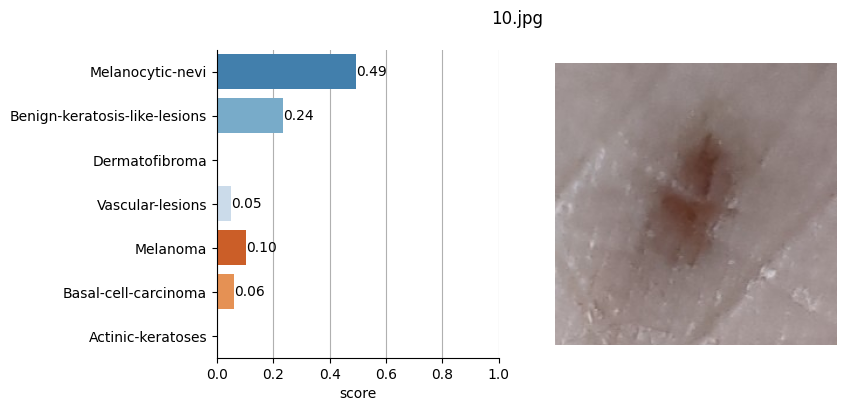

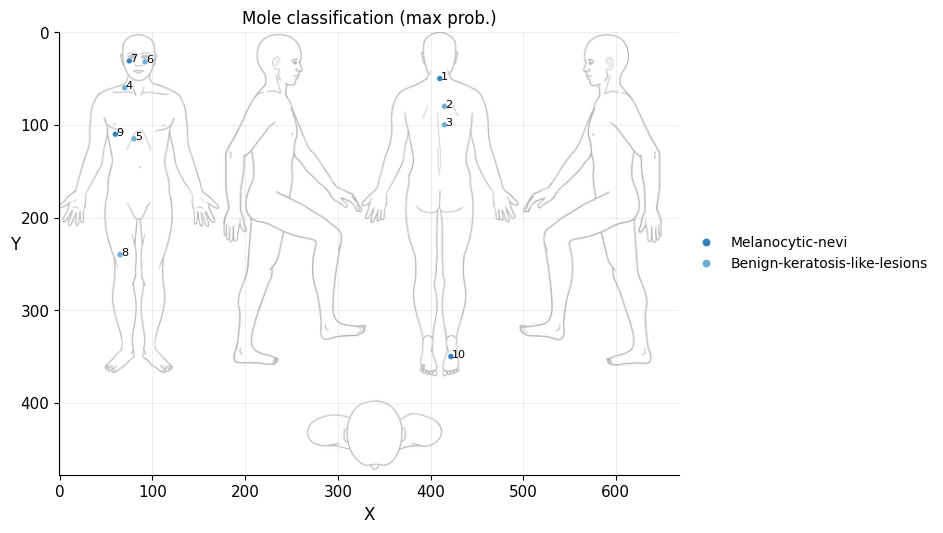

In [9]:
# Instantiate mole classifier
mole_classifier = pipeline(
    "image-classification",
    model="gianlab/swin-tiny-patch4-window7-224-finetuned-skin-cancer",
)

# Define, init lists
diseases = [
    "Melanocytic-nevi",
    "Benign-keratosis-like-lesions",
    "Dermatofibroma",
    "Vascular-lesions",
    "Melanoma",
    "Basal-cell-carcinoma",
    "Actinic-keratoses",
]
palette = "tab20c"
top_labels = []

# Iterate through the moles
for file_name in moles["file"]:
    # Open image file
    with Image.open(path + file_name) as mole_image:
        mole_image.load()

    # Classify mole
    results = mole_classifier(mole_image)

    # Save top-score labels
    top_labels.append(results[0]["label"])

    # Plot result
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    fig.suptitle(f"{file_name}", fontsize=12)

    labels = [result["label"] for result in results]
    scores = [result["score"] for result in results]
    sns.barplot(
        x=scores,
        y=labels,
        ax=ax[0],
        order=diseases,
        hue=labels,
        hue_order=diseases,
        palette=palette,
    )

    for i in range(len(diseases)):
        ax[0].bar_label(ax[0].containers[i], fmt="%.2f", label_type="edge", fontsize=10)
    ax[0].set_xlim(0, 1)
    ax[0].set_xlabel("score")
    ax[0].grid(axis="x")
    ax[0].set_axisbelow(True)

    ax[1].imshow(mole_image)
    ax[1].set_axis_off()

    sns.despine()
    plt.show()


# Plot max prob over body map
fig, ax = plt.subplots(figsize=(8, 8))

ax.imshow(bodyimage, alpha=0.3)

sns.scatterplot(
    x="x",
    y="y",
    data=moles,
    ax=ax,
    hue=top_labels,
    palette=palette,
    size=3,
    legend="full",
)
add = 1.0
for index, row in moles.iterrows():
    ax.text(row["x"] + add, row["y"] + add, str(index + 1), size=8)

ax.grid(axis="both", alpha=0.2)
ax.set_axisbelow(True)
ax.tick_params(axis="x", labelsize=11, rotation=0)
ax.tick_params(axis="y", labelsize=11)
ax.set_title("Mole classification (max prob.)", size=12)
ax.set_xlabel("X", size=12)
ax.set_ylabel("Y", size=12, rotation=0)
h, l = ax.get_legend_handles_labels()
ax.legend(
    h[0:2],
    l[0:2],
    bbox_to_anchor=(1.0, 0.5),
    loc="center left",
    fontsize=10,
    frameon=False,
)
sns.despine()

plt.show()

## Conclusion

It doesn't seem like I should worry, the results obtained don't seem to raise suspicions regarding melanomas. Nevertheless, I shouldn't refrain from consulting a doctor, my wife is right. This project remains nothing more than a simple exercise in which I've only used one image classification model. I've also noticed that the quality of the photographs matters, as in certain slightly blurry (not well-focused) images, the model yielded higher probabilities of malignant eruption.